In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.model_selection import train_test_split

## Importing and cleaning data

In [2]:
t1 = pd.read_csv('Turbine1.csv', skiprows = [1], sep = ';', decimal = ',')
t2 = pd.read_csv('Turbine2.csv', skiprows = [1], sep = ';', decimal = ',')

In [3]:
# formatting names
t1 = t1.rename(columns = lambda x: x.lstrip())
t2 = t2.rename(columns = lambda x: x.lstrip())

In [4]:
# formatting dates
t1['Dat/Zeit'] = pd.to_datetime(t1['Dat/Zeit'], format = '%d.%m.%Y, %H:%M')
t2['Dat/Zeit'] = pd.to_datetime(t2['Dat/Zeit'], format = '%d.%m.%Y, %H:%M')

Text(0.5, 1.0, 'Turbine 2')

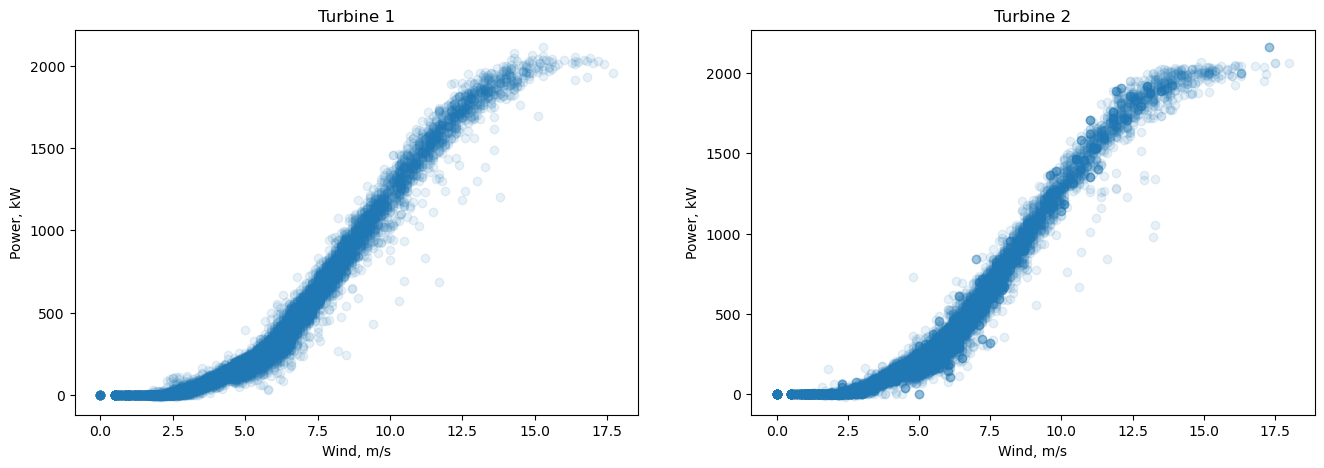

In [198]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,5))
ax1.scatter(t1['Wind'], t1['Leistung'], alpha = 0.1)
ax2.scatter(t2['Wind'], t2['Leistung'], alpha = 0.1)
ax1.set_xlabel('Wind, m/s')
ax2.set_xlabel('Wind, m/s')
ax1.set_ylabel('Power, kW')
ax2.set_ylabel('Power, kW')
ax1.set_title('Turbine 1')
ax2.set_title('Turbine 2')

## Predicting power from wind only - polynomial regression

The curve seems simple enough to be predicted by a simple polynomial regression, so I chose that as the initial model. (When I add more features later I changed the model to Random Forest). The polynomial regression has very few parameters (after playing around, 5'th order polynomial, so 6 parameters, seemed to be the sweet spot in terms of model accuracy), so it won't be prone to overfitting at all. Of course, once extra features are added, capturing interactions between them might be difficult with a linear/polynomial regression.

In [200]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

PF = PolynomialFeatures(degree = 5, include_bias = False)

x1 = PF.fit_transform(np.array(t1['Wind']).reshape(-1,1))
x2 = PF.fit_transform(np.array(t2['Wind']).reshape(-1,1))

LR1 = LinearRegression()
LR2 = LinearRegression()

LR1.fit(x1, t1['Leistung'])
LR2.fit(x2, t2['Leistung'])

w1 = np.linspace(t1['Wind'].min(), t1['Wind'].max(), 1000)
w2 = np.linspace(t2['Wind'].min(), t2['Wind'].max(), 1000)

x1_pred = PF.fit_transform(w1.reshape(-1,1))
x2_pred = PF.fit_transform(w2.reshape(-1,1))

y1_pred = LR1.predict(x1_pred)
y2_pred = LR2.predict(x2_pred)

# we define the residual as real value - model prediction
t1['residual'] = t1['Leistung'] - LR1.predict(x1)
t2['residual'] = t2['Leistung'] - LR2.predict(x2)

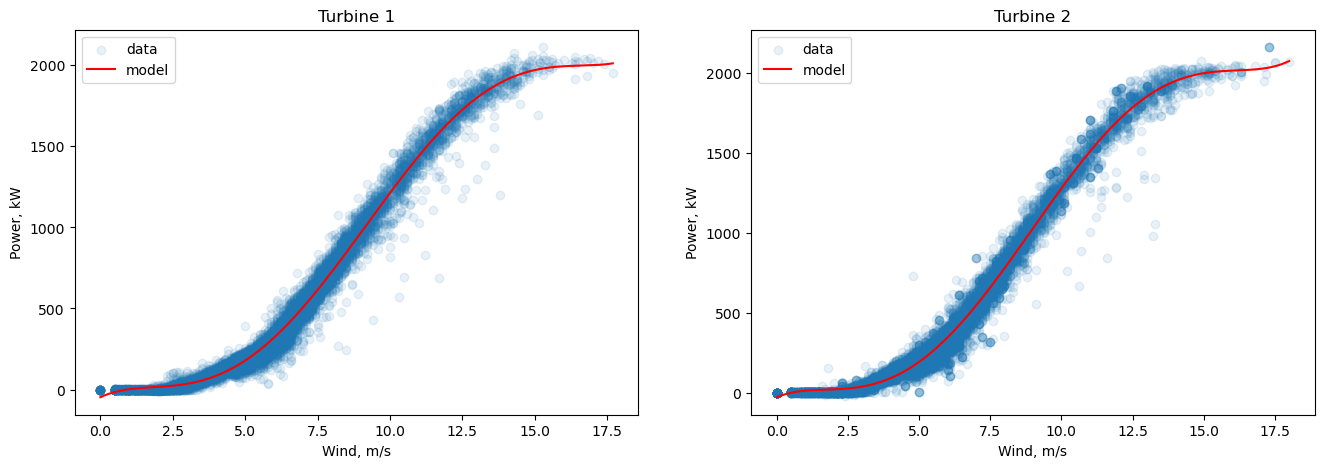

In [201]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,5))
ax1.scatter(t1['Wind'], t1['Leistung'], alpha = 0.1, label = 'data')
ax1.plot(w1, y1_pred, color = 'red', label = 'model')
ax2.scatter(t2['Wind'], t2['Leistung'], alpha = 0.1, label = 'data')
ax2.plot(w2, y2_pred, color = 'red', label = 'model')
ax1.set_xlabel('Wind, m/s')
ax2.set_xlabel('Wind, m/s')
ax1.set_ylabel('Power, kW')
ax2.set_ylabel('Power, kW')
ax1.set_title('Turbine 1')
ax2.set_title('Turbine 2')
ax1.legend()
ax2.legend()

For the metric to evaluate model performance, I chose the R^2 value, as it is easily interpretable. For the Random Forest model with extra features I do a train-test split evaluate the R^2 value on a testing dataset, however for the polynomial regression with 6 parameters, overfitting is virtually impossible with this dataset size so I train and evaluate model performance on the same dataset.

In [204]:
from sklearn.metrics import r2_score

print(f"Turbine 1: r2 value of {r2_score(t1['Leistung'], LR1.predict(x1))}")
print(f"Turbine2: r2 value of {r2_score(t2['Leistung'], LR2.predict(x2))}")

Turbine 1: r2 value of 0.9870077425774122
Turbine2: r2 value of 0.9853701531089339


Visually, the model fits the data close to as well as it could, given only one feature - wind speed. The residuals are plotted below.

Text(0.5, 1.0, 'Residual plot, turbine 2')

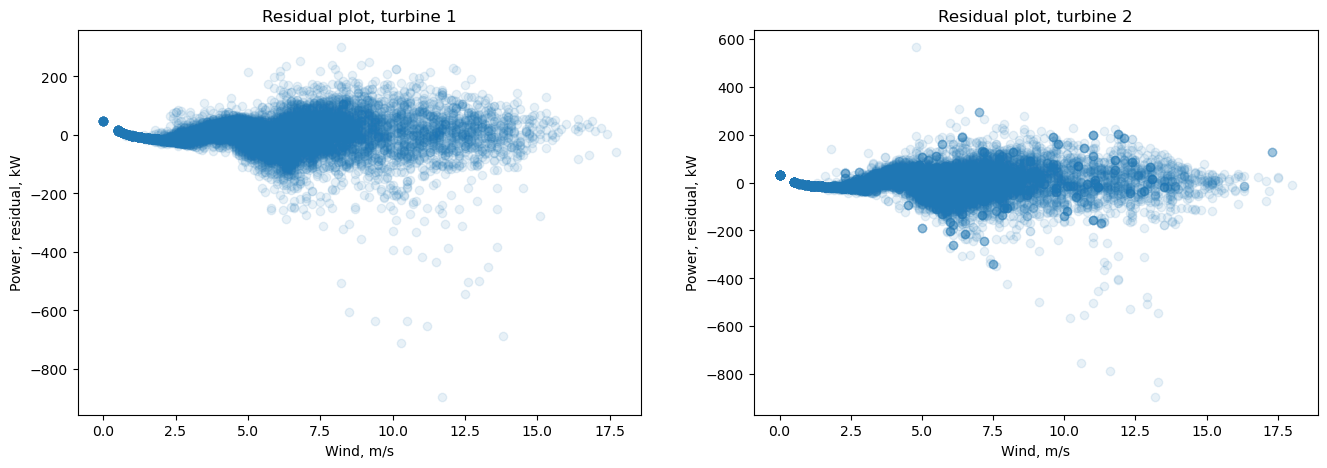

In [206]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,5))
ax1.scatter(t1['Wind'], t1['residual'], alpha = 0.1)
ax2.scatter(t2['Wind'], t2['residual'], alpha = 0.1)
ax1.set_xlabel('Wind, m/s')
ax2.set_xlabel('Wind, m/s')
ax1.set_ylabel('Power, residual, kW')
ax2.set_ylabel('Power, residual, kW')
ax1.set_title('Residual plot, turbine 1')
ax2.set_title('Residual plot, turbine 2')

## Other features

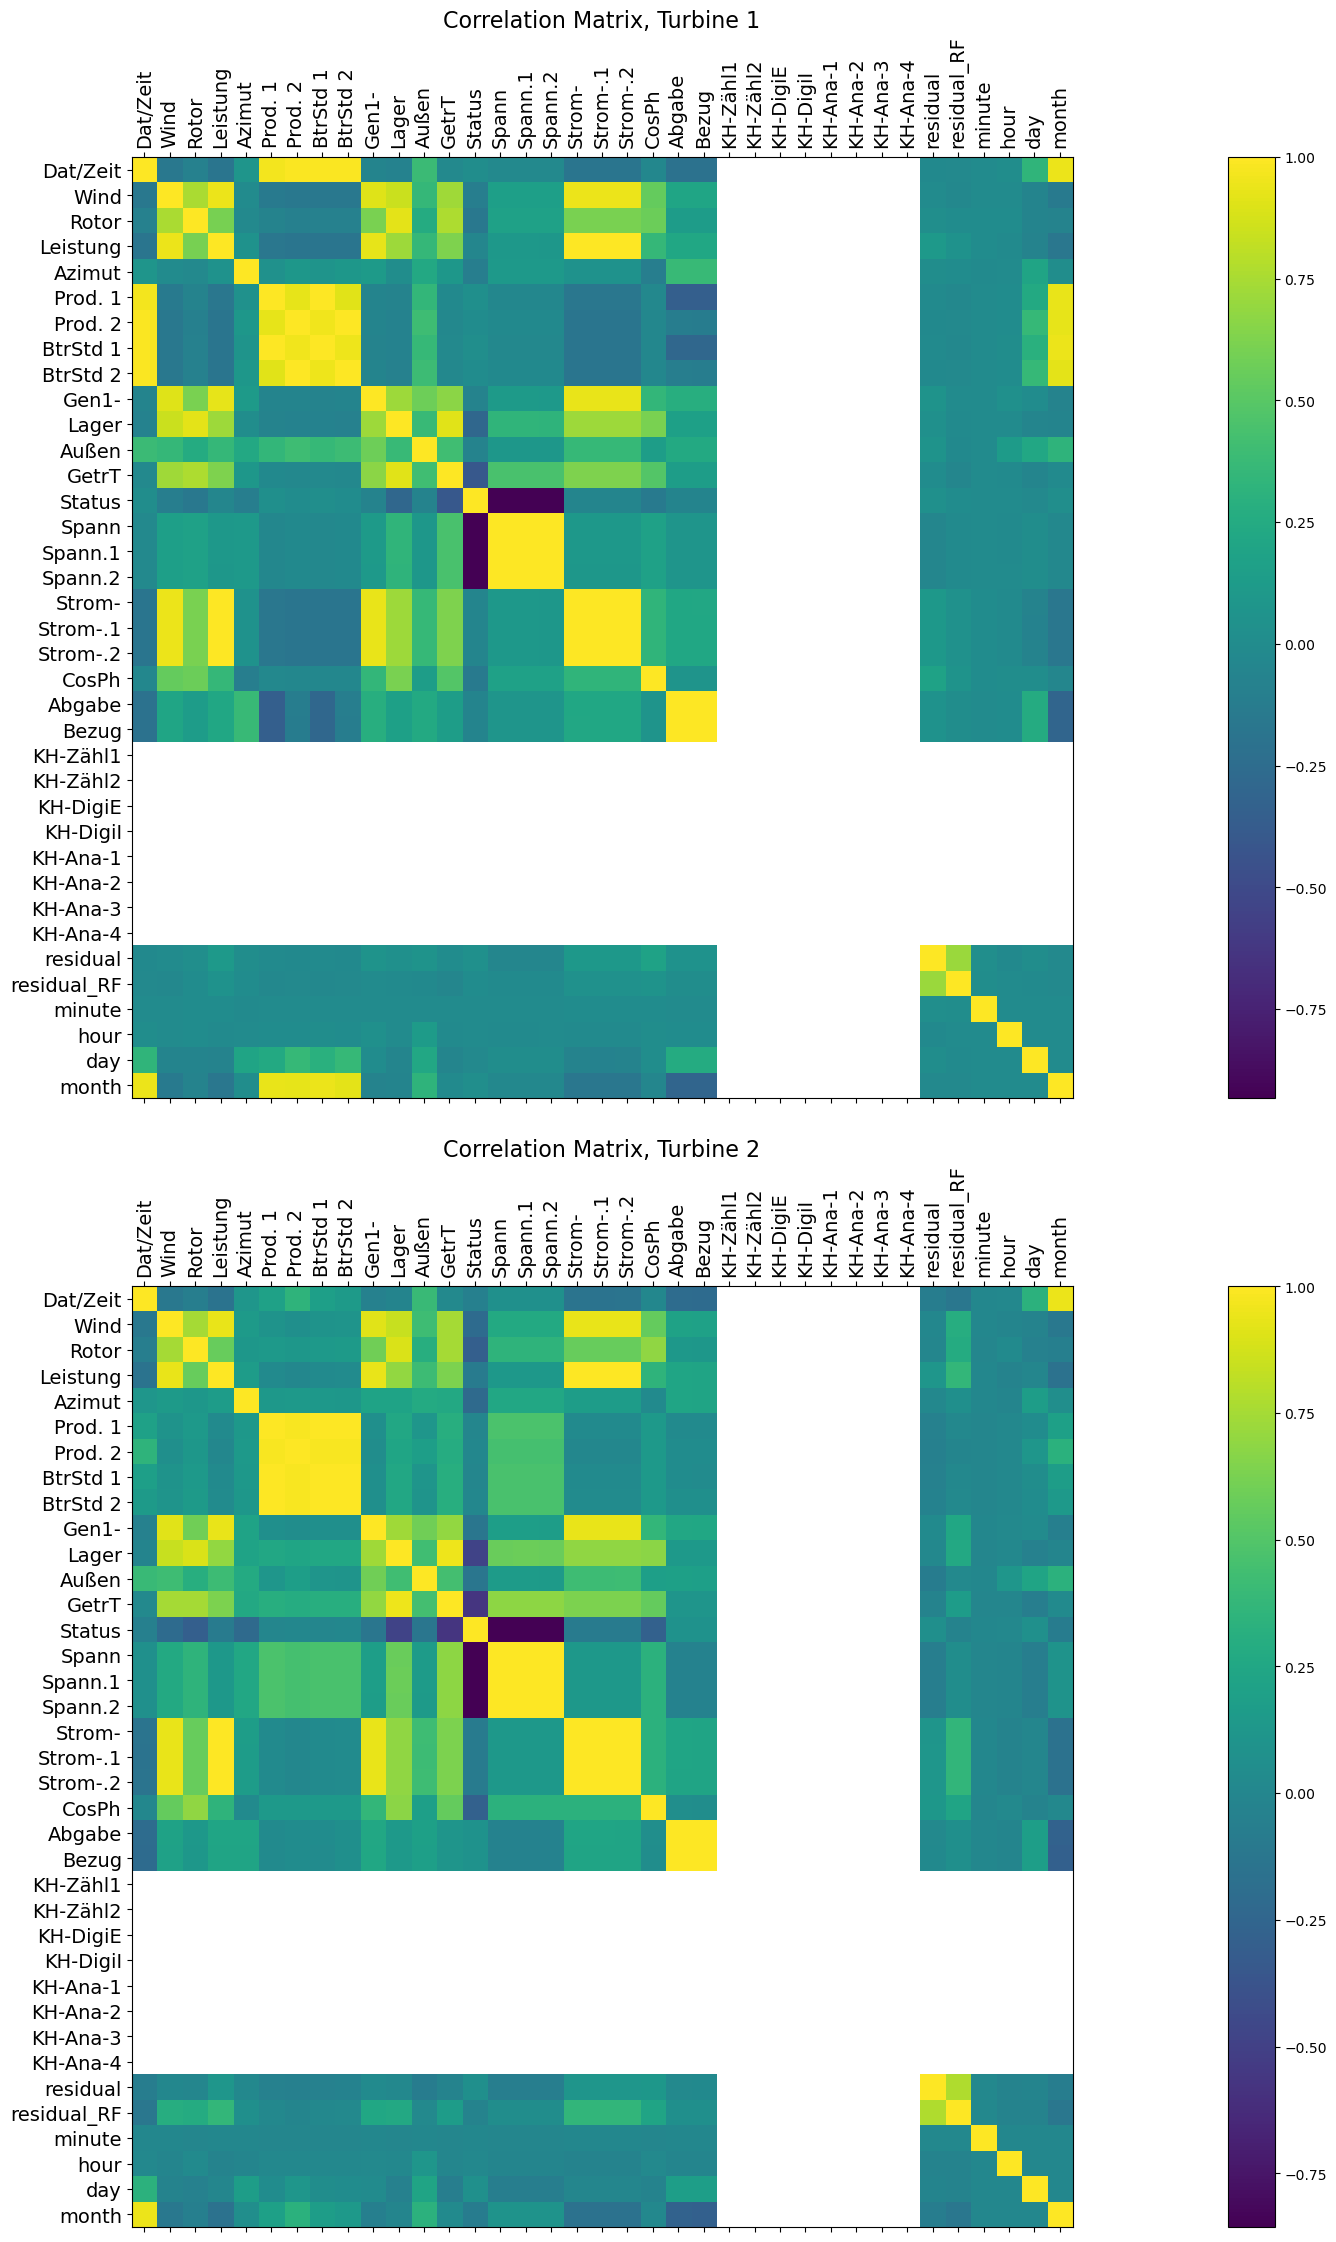

In [152]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize = (40,15))
plt.subplots_adjust(bottom = -0.5)
z1 = ax1.matshow(t1.corr())
ax1.set_xticks(range(t1.shape[1]), t1.columns, fontsize=14, rotation=90)
ax1.set_yticks(range(t1.shape[1]), t1.columns, fontsize=14)
plt.colorbar(z1, ax = ax1)
cb.ax.tick_params(labelsize=14)
ax1.set_title('Correlation Matrix, Turbine 1', fontsize=16);

z2 = ax2.matshow(t2.corr())
ax2.set_xticks(range(t2.shape[1]), t2.columns, fontsize=14, rotation=90)
ax2.set_yticks(range(t2.shape[1]), t2.columns, fontsize=14)
plt.colorbar(z2, ax = ax2)
cb.ax.tick_params(labelsize=14)
ax2.set_title('Correlation Matrix, Turbine 2', fontsize=16);

In [148]:
# correlations of wind power with other features
print(t1.corr()['Leistung'])

Dat/Zeit      -0.179975
Wind           0.946330
Rotor          0.602968
Leistung       1.000000
Azimut         0.049676
Prod. 1       -0.168306
Prod. 2       -0.180424
BtrStd 1      -0.180187
BtrStd 2      -0.179185
Gen1-          0.931303
Lager          0.714281
Außen          0.357772
GetrT          0.622470
Status        -0.048963
Spann          0.094612
Spann.1        0.097258
Spann.2        0.091750
Strom-         0.998496
Strom-.1       0.998323
Strom-.2       0.998467
CosPh          0.357148
Abgabe         0.220495
Bezug          0.220694
KH-Zähl1            NaN
KH-Zähl2            NaN
KH-DigiE            NaN
KH-DigiI            NaN
KH-Ana-1            NaN
KH-Ana-2            NaN
KH-Ana-3            NaN
KH-Ana-4            NaN
residual       0.113984
residual_RF    0.051213
minute         0.004538
hour          -0.010207
day           -0.070131
month         -0.168171
Name: Leistung, dtype: float64


It seems that Leistung (mechanical power) correlates almost perfectly with all the variables starting with "Strom" (I assume the electrical power). I would guess that this isn't accessible when predicting the power in a realistic scenario, only the past values, so I decided it would be more in the spirit of the task to first train a model without those features, and then for completeness' sake include them.

As for which features to include, I took the 7 features with highest correlation to Leistung (excluding the "Strom" ones) - Wind, Rotor, Azimut (relating to the wind) and Gen1-, Lager, Außen & GetrT (temperatures). Visually, out of the 7 features no two had a correlation high enough to warrant only including one of the pair.

## Random Forest with more features

For the model, I chose Random Forest, as it is robust to outliers, often doesn't require hyperparameter tuning for good performance, can handle non-linear relationships easily, and isn't very prone to overfitting. Its disadvantages are that it can take a while to train for large datasets (so not necessarily the most scalable), but it only ever took me ~10 seconds for the turbine data. It can also underfit compared to gradient-boosted methods like XGBoost, but in this instance it didn't seem to be the case.

In [157]:
from sklearn.ensemble import RandomForestRegressor

features = ['Wind','Rotor', 'Azimut', 'Lager', 'Außen', 'Gen1-', 'GetrT']
x1 = np.array(t1[features])
x2 = np.array(t2[features])
RF1 = RandomForestRegressor()
RF2 = RandomForestRegressor()

x1_train, x1_test, y1_train, y1_test = train_test_split(x1, t1['Leistung'], train_size = 0.8)
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, t2['Leistung'], train_size = 0.8)

RF1.fit(x1_train, y1_train)
RF2.fit(x2_train, y2_train)

y1_pred = RF1.predict(x1_test)
y2_pred = RF2.predict(x2_test)

y1_train_pred = RF1.predict(x1_train)
y2_train_pred = RF2.predict(x2_train)

In [158]:
print(f"Turbine 1: R squared value of {r2_score(y1_train, y1_train_pred)} on training set, {r2_score(y1_test, y1_pred)} on testing set")
print(f"Turbine 2: R squared value of {r2_score(y2_train, y2_train_pred)} on training set, {r2_score(y2_test, y2_pred)} on testing set")

t1['residual_RF'] = t1['Leistung'] - RF1.predict(x1)
t2['residual_RF'] = t2['Leistung'] - RF2.predict(x2) 

Turbine 1: R squared value of 0.9988491348703749 on training set, 0.9924853164574717 on testing set
Turbine 2: R squared value of 0.99895537349787 on training set, 0.9934493935758735 on testing set


Text(0.5, 1.0, 'Residual plot, turbine 2')

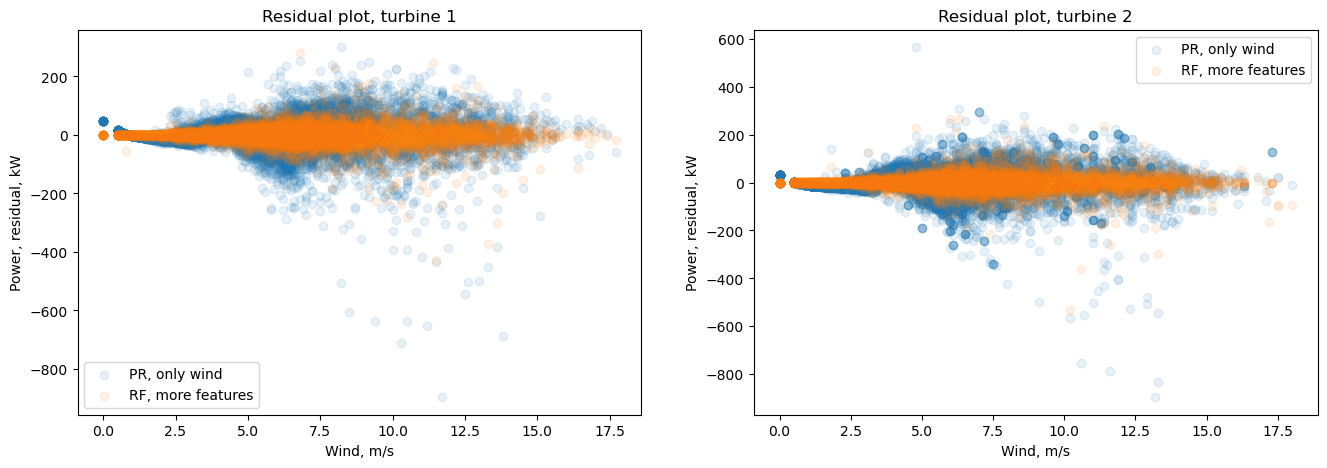

In [208]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,5))
ax1.scatter(t1['Wind'], t1['residual'], alpha = 0.1, label = 'PR, only wind')
ax1.scatter(t1['Wind'], t1['residual_RF'], alpha = 0.1, label = 'RF, more features')
ax2.scatter(t2['Wind'], t2['residual'], alpha = 0.1, label = 'PR, only wind')
ax2.scatter(t2['Wind'], t2['residual_RF'], alpha = 0.1, label = 'RF, more features')
ax1.legend()
ax2.legend()
ax1.set_xlabel('Wind, m/s')
ax2.set_xlabel('Wind, m/s')
ax1.set_ylabel('Power, residual, kW')
ax2.set_ylabel('Power, residual, kW')
ax1.set_title('Residual plot, turbine 1')
ax2.set_title('Residual plot, turbine 2')




Significantly better model performance both in terms of R^2 and visually from the residuals. I was considering also performing cross-validation for a better estimate of model performance, but given the extremely high R^2 value, it is highly unlikely that the model performance is only from a lucky train-test split.

For completion sake, we now try to model the power consumption with the "Strom" variables

Turbine 1: R squared value of 0.9998145205132771 on training set, 0.9985810115857606 on testing set
Turbine 2: R squared value of 0.9998749247575374 on training set, 0.9990955521548213 on testing set


Text(0.5, 1.0, 'Residual plot, turbine 2')

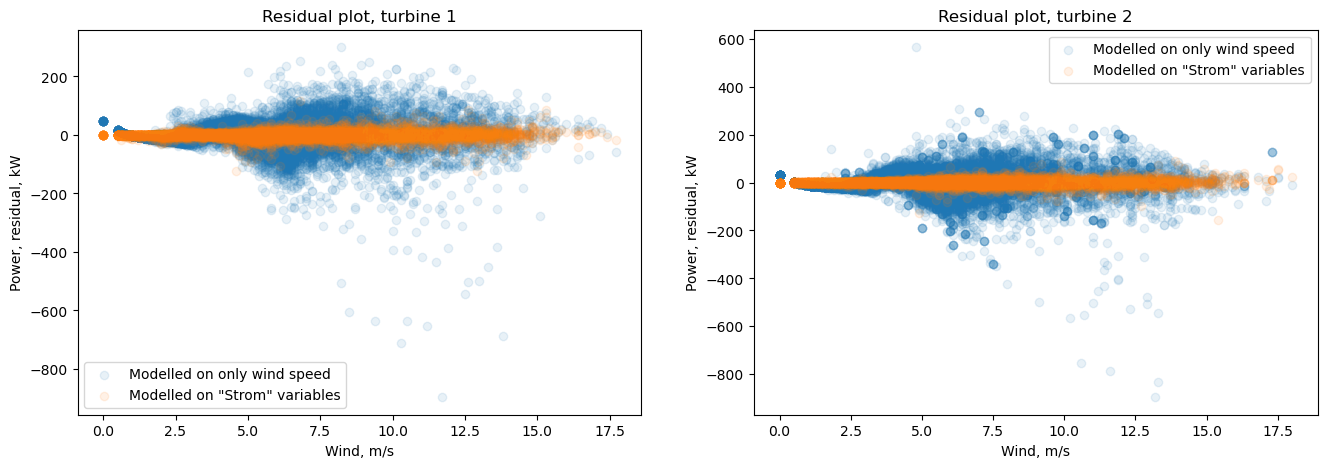

In [175]:
more_features = ['Strom-', 'Strom-.1', 'Strom-.2']

x1_mf = np.array(t1[more_features])
x2_mf = np.array(t2[more_features])

x1_train_mf, x1_test_mf, y1_train_mf, y1_test_mf = train_test_split(x1_mf, t1['Leistung'], train_size = 0.8)
x2_train_mf, x2_test_mf, y2_train_mf, y2_test_mf = train_test_split(x2_mf, t2['Leistung'], train_size = 0.8)

RF1_mf = RandomForestRegressor()
RF2_mf = RandomForestRegressor()

RF1_mf.fit(x1_train_mf, y1_train_mf)
RF2_mf.fit(x2_train_mf, y2_train_mf)

y1_pred_mf = RF1_mf.predict(x1_test_mf)
y2_pred_mf = RF2_mf.predict(x2_test_mf)

y1_train_pred_mf = RF1_mf.predict(x1_train_mf)
y2_train_pred_mf = RF2_mf.predict(x2_train_mf)

print(f"Turbine 1: R squared value of {r2_score(y1_train_mf, y1_train_pred_mf)} on training set, {r2_score(y1_test_mf, y1_pred_mf)} on testing set")
print(f"Turbine 2: R squared value of {r2_score(y2_train_mf, y2_train_pred_mf)} on training set, {r2_score(y2_test_mf, y2_pred_mf)} on testing set")

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,5))
ax1.scatter(t1['Wind'], t1['residual'], alpha = 0.1, label = 'Modelled on only wind speed')
ax1.scatter(t1['Wind'], t1['Leistung'] - RF1_mf.predict(x1_mf), alpha = 0.1, label = 'Modelled on "Strom" variables')
ax2.scatter(t2['Wind'], t2['residual'], alpha = 0.1, label = 'Modelled on only wind speed')
ax2.scatter(t2['Wind'], t2['Leistung'] - RF2_mf.predict(x2_mf), alpha = 0.1, label = 'Modelled on "Strom" variables')
ax1.legend()
ax2.legend()
ax1.set_xlabel('Wind, m/s')
ax2.set_xlabel('Wind, m/s')
ax1.set_ylabel('Power, residual, kW')
ax2.set_ylabel('Power, residual, kW')
ax1.set_title('Residual plot, turbine 1')
ax2.set_title('Residual plot, turbine 2')

As expected from the almost 100% correlation, there are no "anomalies" with respect to this model. But it is not very meaningful to talk about anomalies in this context, as, in my opinion, anomalies should be defined with respect to external variables such as wind speed.

## When do anomalies occur?

In this context, I first provide two definitions for an anomaly:

1. As a significant deviation in power output (Leistung) from that predicted by the wind speed (let's call it type A)
2. As a significant deviation in power output (Leistung) from that predicted by the Random Forest model which also uses wind and temperature information (call it type B)

By significant, I set the limit as 5 standard deviations of the residual. This is, of course, slightly arbitrary, and given some shareholder input, could be changed to a more informed number.

In [177]:
anomaly1A = t1['residual'].abs() > 5 * t1['residual'].std()
anomaly2A = t2['residual'].abs() > 5 * t2['residual'].std()
anomaly1B = t1['residual_RF'].abs() > 5 * t1['residual_RF'].std()
anomaly2B = t2['residual_RF'].abs() > 5 * t2['residual_RF'].std()

print(f"Based on our definition, {100*sum(anomaly1A) / len(anomaly1A)}% of datapoints are type A anomalies for turbine 1")
print(f"Based on our definition, {100*sum(anomaly2A) / len(anomaly2A)}% of datapoints are type A anomalies for turbine 2")
print(f"Based on our definition, {100*sum(anomaly1B) / len(anomaly1B)}% of datapoints are type B anomalies for turbine 1")
print(f"Based on our definition, {100*sum(anomaly2B) / len(anomaly2B)}% of datapoints are type B anomalies for turbine 2")

Based on our definition, 0.2594825612455163% of datapoints are type A anomalies for turbine 1
Based on our definition, 0.3052736014653133% of datapoints are type A anomalies for turbine 2
Based on our definition, 0.5113332824543998% of datapoints are type B anomalies for turbine 1
Based on our definition, 0.48080592230786845% of datapoints are type B anomalies for turbine 2


Note that there are more type B anomalies - this is because the residuals are on average smaller for the RF model with more features, so the standard deviation is smaller, and more datapoints fit outside 5x standard deviation of the residual

Now, let's investigate if there are more anomalies at certain timeframes (months, days, hours, minutes)

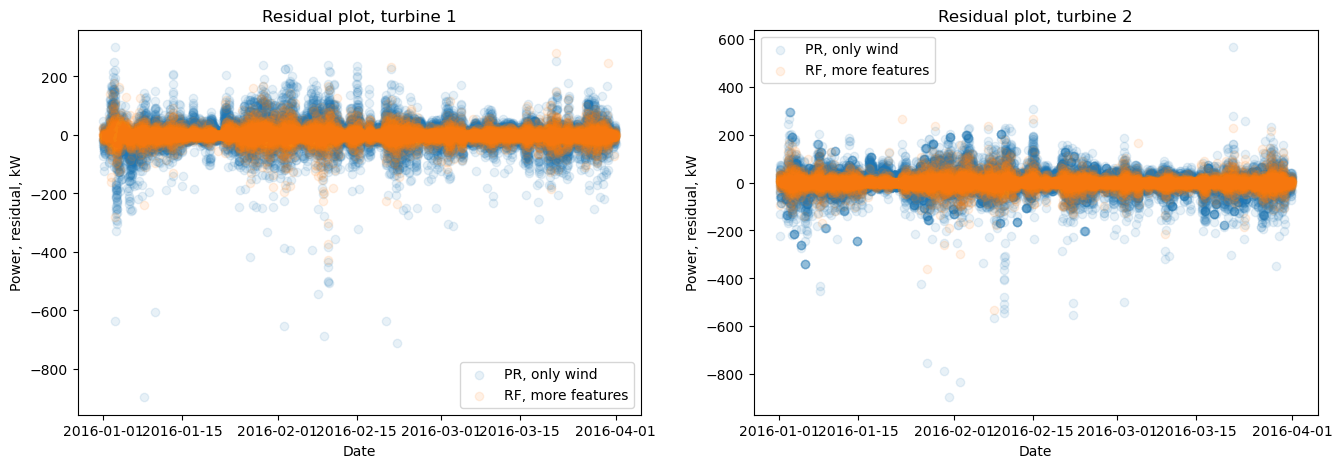

In [209]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,5))
ax1.scatter(t1['Dat/Zeit'], t1['residual'], alpha = 0.1, label = 'PR, only wind')
ax1.scatter(t1['Dat/Zeit'], t1['residual_RF'], alpha = 0.1, label = 'RF, more features')
ax2.scatter(t2['Dat/Zeit'], t2['residual'], alpha = 0.1, label = 'PR, only wind')
ax2.scatter(t2['Dat/Zeit'], t2['residual_RF'], alpha = 0.1, label = 'RF, more features')
ax1.set_title('Residual plot, turbine 1')
ax2.set_title('Residual plot, turbine 2')
ax1.set_xlabel('Date')
ax2.set_xlabel('Date')
ax1.set_ylabel('Power, residual, kW')
ax2.set_ylabel('Power, residual, kW')
ax1.legend()
ax2.legend()

No obvious trend with respect to date

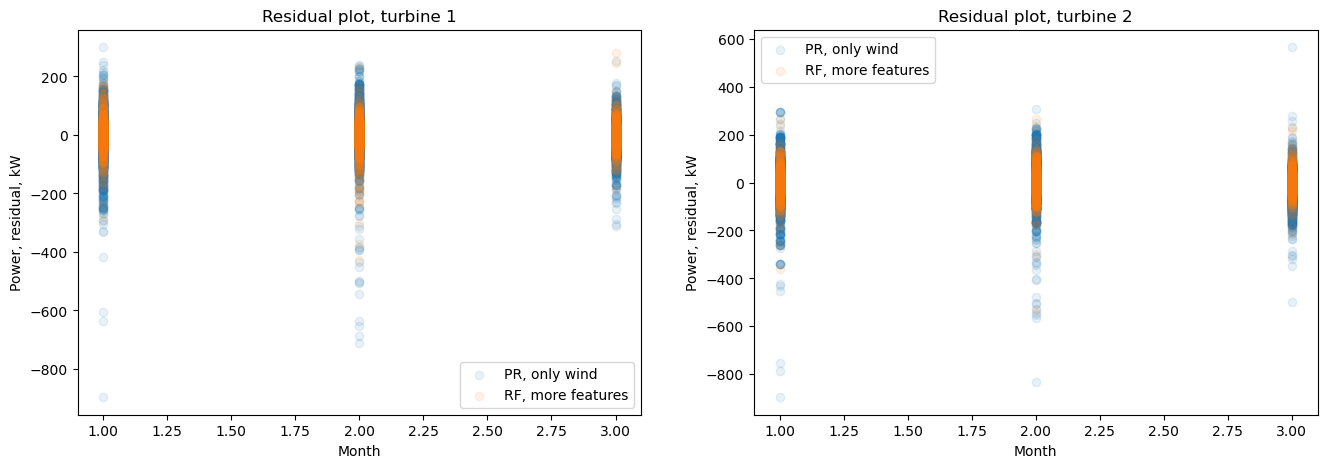

In [212]:
t1['month'] = t1['Dat/Zeit'].apply(lambda x: x.month)
t2['month'] = t2['Dat/Zeit'].apply(lambda x: x.month)

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,5))
ax1.scatter(t1['month'], t1['residual'], alpha = 0.1, label = 'PR, only wind')
ax1.scatter(t1['month'], t1['residual_RF'], alpha = 0.1, label = 'RF, more features')
ax2.scatter(t2['month'], t2['residual'], alpha = 0.1, label = 'PR, only wind')
ax2.scatter(t2['month'], t2['residual_RF'], alpha = 0.1, label = 'RF, more features')
ax1.set_title('Residual plot, turbine 1')
ax2.set_title('Residual plot, turbine 2')
ax1.set_xlabel('Month')
ax2.set_xlabel('Month')
ax1.set_ylabel('Power, residual, kW')
ax2.set_ylabel('Power, residual, kW')
ax1.legend()
ax2.legend()

No obvious trend with respect to month

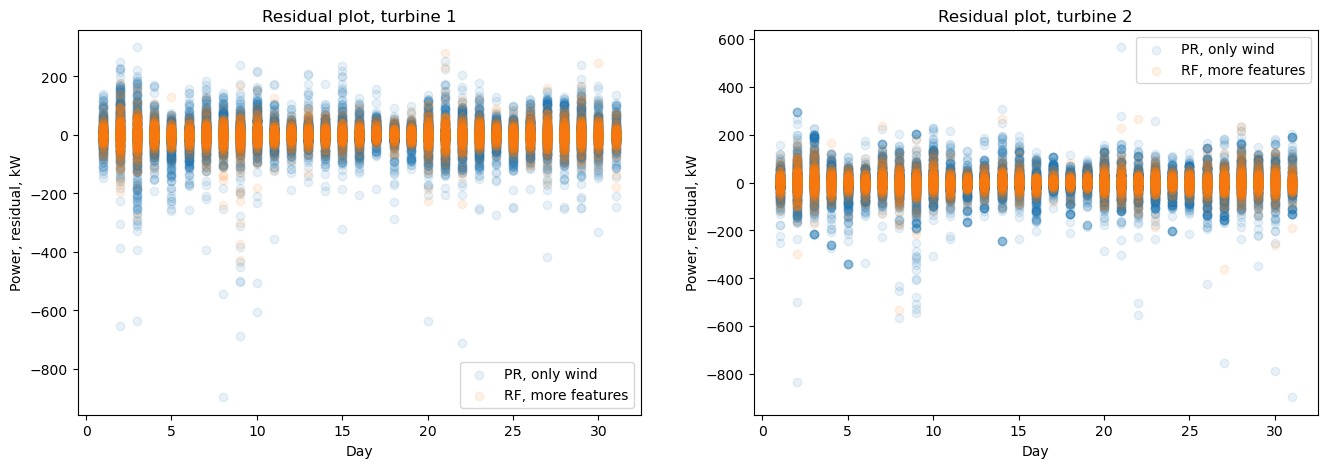

In [213]:
t1['day'] = t1['Dat/Zeit'].apply(lambda x: x.day)
t2['day'] = t2['Dat/Zeit'].apply(lambda x: x.day)

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,5))
ax1.scatter(t1['day'], t1['residual'], alpha = 0.1, label = 'PR, only wind')
ax1.scatter(t1['day'], t1['residual_RF'], alpha = 0.1, label = 'RF, more features')
ax2.scatter(t2['day'], t2['residual'], alpha = 0.1, label = 'PR, only wind')
ax2.scatter(t2['day'], t2['residual_RF'], alpha = 0.1, label = 'RF, more features')
ax1.set_title('Residual plot, turbine 1')
ax2.set_title('Residual plot, turbine 2')
ax1.set_xlabel('Day')
ax2.set_xlabel('Day')
ax1.set_ylabel('Power, residual, kW')
ax2.set_ylabel('Power, residual, kW')
ax1.legend()
ax2.legend()

No obvious trend with respect to day

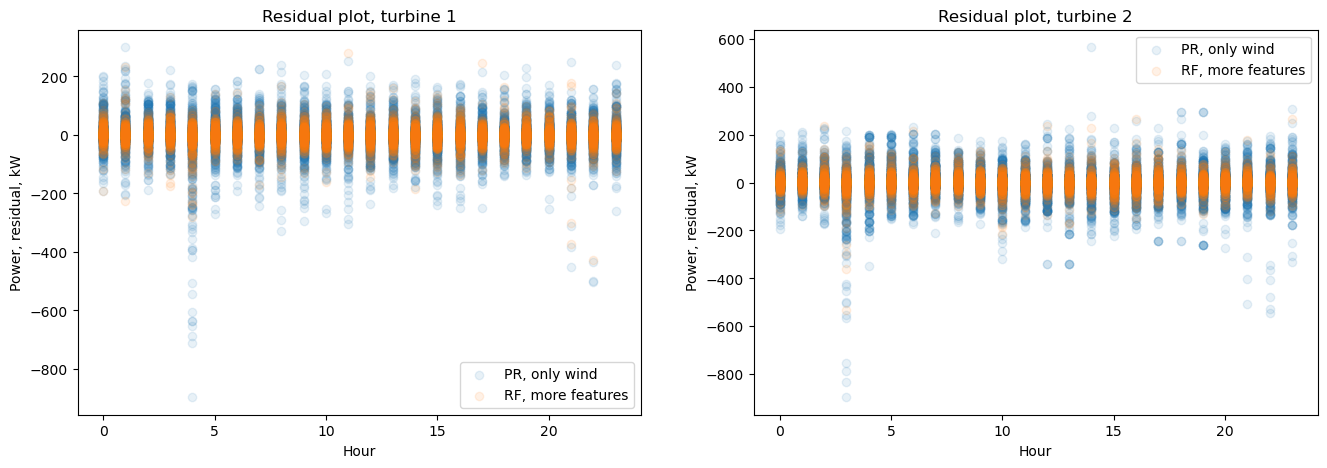

In [214]:
t1['hour'] = t1['Dat/Zeit'].apply(lambda x: x.hour)
t2['hour'] = t2['Dat/Zeit'].apply(lambda x: x.hour)

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,5))
ax1.scatter(t1['hour'], t1['residual'], alpha = 0.1, label = 'PR, only wind')
ax1.scatter(t1['hour'], t1['residual_RF'], alpha = 0.1, label = 'RF, more features')
ax2.scatter(t2['hour'], t2['residual'], alpha = 0.1, label = 'PR, only wind')
ax2.scatter(t2['hour'], t2['residual_RF'], alpha = 0.1, label = 'RF, more features')
ax1.set_title('Residual plot, turbine 1')
ax2.set_title('Residual plot, turbine 2')
ax1.set_xlabel('Hour')
ax2.set_xlabel('Hour')
ax1.set_ylabel('Power, residual, kW')
ax2.set_ylabel('Power, residual, kW')
ax1.legend()
ax2.legend()

There seems to be a trend in terms of hours! In particular, it seems that most anomalies occur between 4am and 5am for turbine 1, and between 3am and 4am for turbine 2.

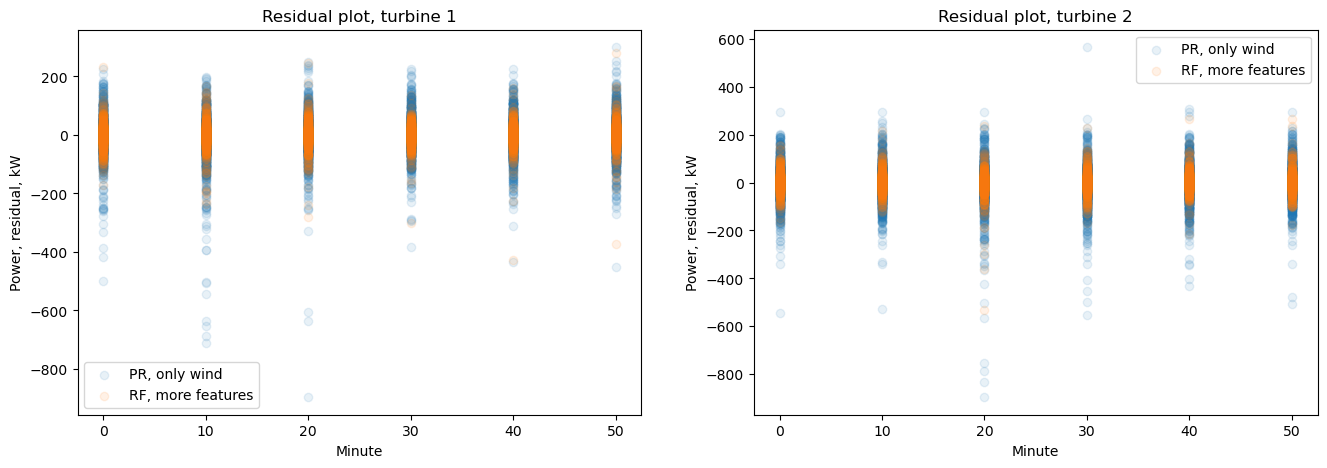

In [221]:
t1['minute'] = t1['Dat/Zeit'].apply(lambda x: x.minute)
t2['minute'] = t2['Dat/Zeit'].apply(lambda x: x.minute)

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,5))
ax1.scatter(t1['minute'], t1['residual'], alpha = 0.1, label = 'PR, only wind')
ax1.scatter(t1['minute'], t1['residual_RF'], alpha = 0.1, label = 'RF, more features')
ax2.scatter(t2['minute'], t2['residual'], alpha = 0.1, label = 'PR, only wind')
ax2.scatter(t2['minute'], t2['residual_RF'], alpha = 0.1, label = 'RF, more features')
ax1.set_title('Residual plot, turbine 1')
ax2.set_title('Residual plot, turbine 2')
ax1.set_xlabel('Minute')
ax2.set_xlabel('Minute')
ax1.set_ylabel('Power, residual, kW')
ax2.set_ylabel('Power, residual, kW')
ax1.legend()
ax2.legend()

No obvious trend with respect to time within the hour.

Let's now quantify the observation that most anomalies occur within a certain hour.

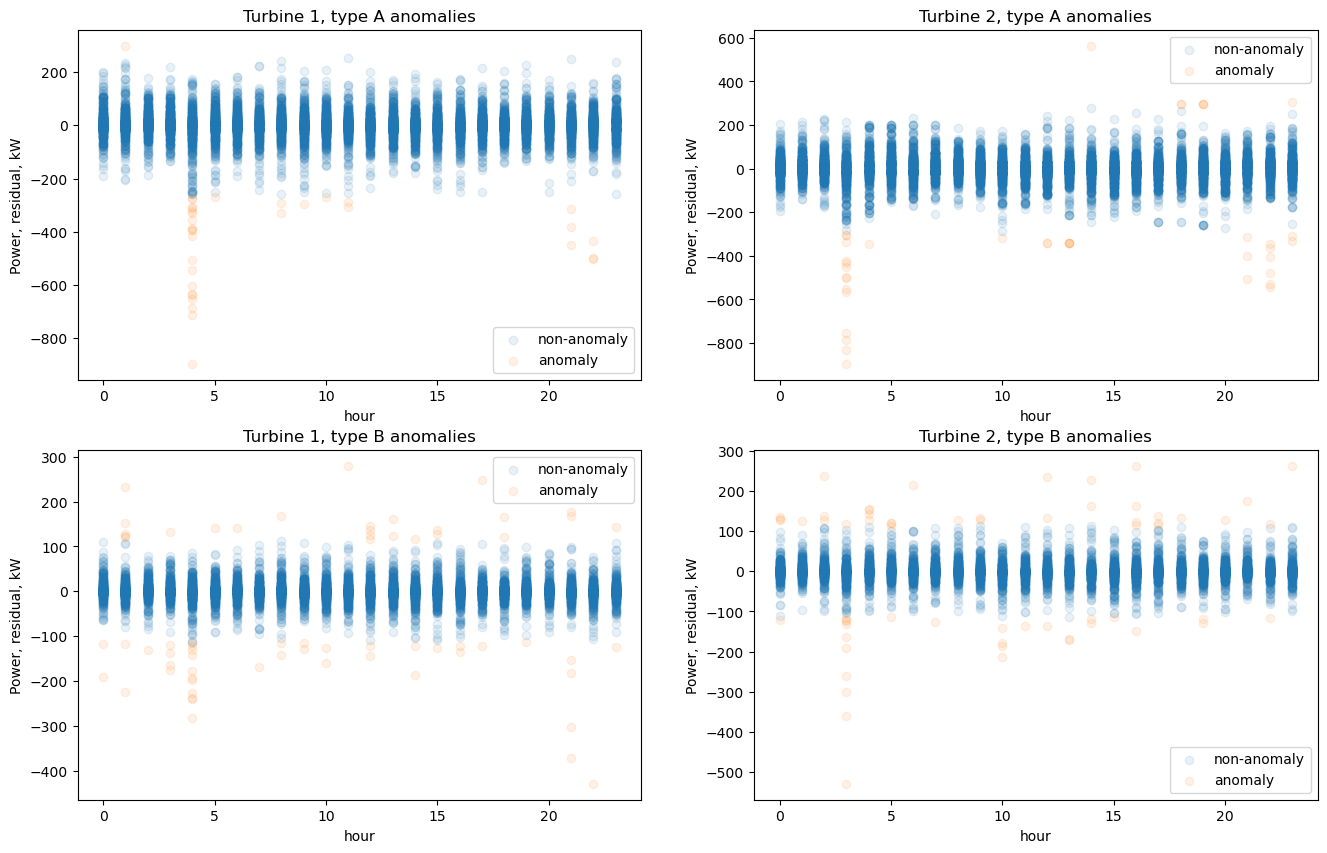

In [188]:
condition1 = t1['hour'] == 4
condition2 = t2['hour'] == 3

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (16,10))
ax1.scatter(t1[~anomaly1A]['hour'], t1[~anomaly1A]['residual'], alpha = 0.1, label = 'non-anomaly')
ax1.scatter(t1[anomaly1A]['hour'], t1[anomaly1A]['residual'], alpha = 0.1, label = 'anomaly')
ax2.scatter(t2[~anomaly2A]['hour'], t2[~anomaly2A]['residual'], alpha = 0.1, label = 'non-anomaly')
ax2.scatter(t2[anomaly2A]['hour'], t2[anomaly2A]['residual'], alpha = 0.1, label = 'anomaly')
ax3.scatter(t1[~anomaly1B]['hour'], t1[~anomaly1B]['residual_RF'], alpha = 0.1, label = 'non-anomaly')
ax3.scatter(t1[anomaly1B]['hour'], t1[anomaly1B]['residual_RF'], alpha = 0.1, label = 'anomaly')
ax4.scatter(t2[~anomaly2B]['hour'], t2[~anomaly2B]['residual_RF'], alpha = 0.1, label = 'non-anomaly')
ax4.scatter(t2[anomaly2B]['hour'], t2[anomaly2B]['residual_RF'], alpha = 0.1, label = 'anomaly')
ax1.set_title('Turbine 1, type A anomalies')
ax2.set_title('Turbine 2, type A anomalies')
ax3.set_title('Turbine 1, type B anomalies')
ax4.set_title('Turbine 2, type B anomalies')
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
for ax in (ax1,ax2,ax3,ax4):
    ax.set_xlabel('hour')
    ax.set_ylabel('Power, residual, kW')

In [189]:
print(f"{len(t1[anomaly1A & condition1]) / len(t1[anomaly1A])} of type A anomalies in turbine 1 occur between 4am and 5am")
print(f"{len(t2[anomaly2A & condition2]) / len(t2[anomaly2A])} of type A anomalies in turbine 2 occur between 3am and 4am")
print(f"{len(t1[anomaly1B & condition1]) / len(t1[anomaly1B])} of type B anomalies in turbine 1 occur between 4am and 5am")
print(f"{len(t2[anomaly2B & condition2]) / len(t2[anomaly2B])} of type B anomalies in turbine 2 occur between 3am and 4am")

0.5882352941176471 of type A anomalies in turbine 1 occur between 4am and 5am
0.35 of type A anomalies in turbine 2 occur between 3am and 4am
0.16417910447761194 of type B anomalies in turbine 1 occur between 4am and 5am
0.1746031746031746 of type B anomalies in turbine 2 occur between 3am and 4am


So a very significant part of anomalies occur within a specific hour.

Finally, let's look at a correlation matrix for only the anomalous data (let's pick type A anomalies), to see if there are any correlations among the anomalous data that wasn't in the entirety of the data.

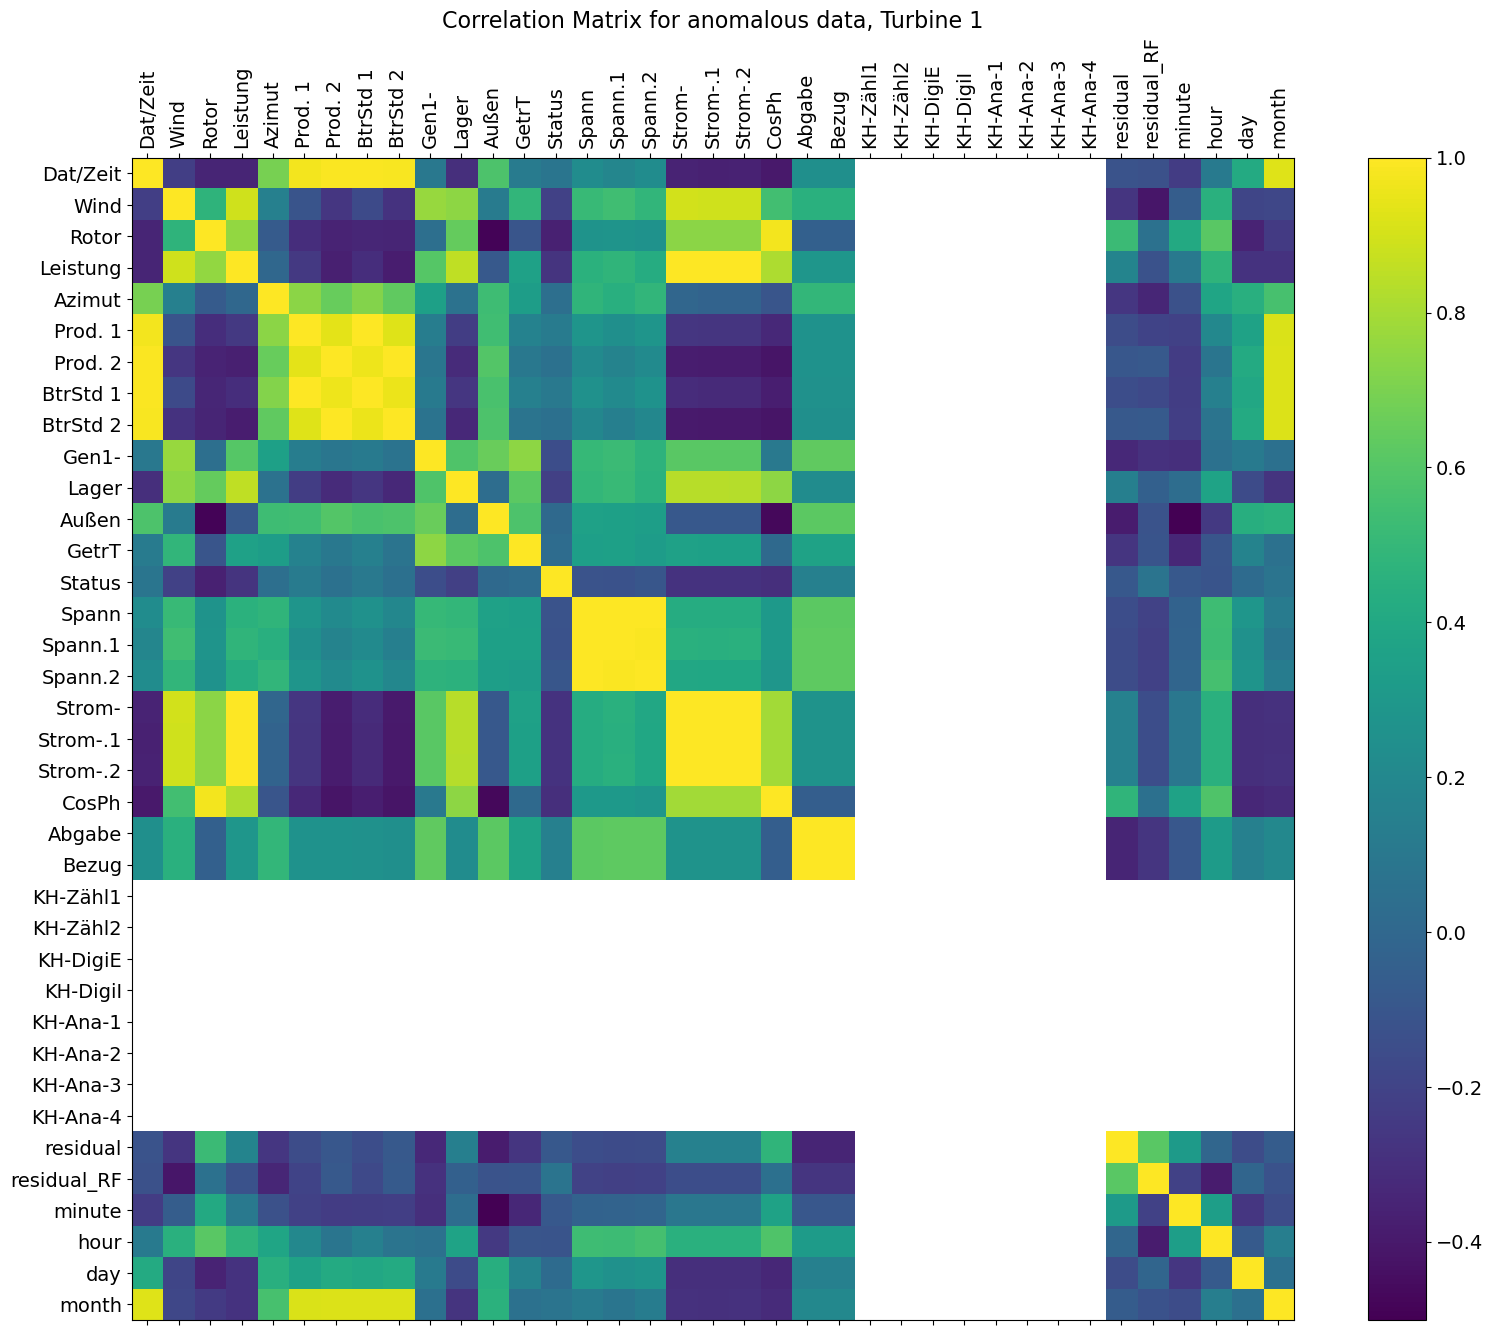

In [192]:
f = plt.figure(figsize=(19, 15))
plt.matshow(t1[anomaly1A].corr(), fignum=f.number)
plt.xticks(range(t1[anomaly1A].shape[1]), t1[anomaly1A].columns, fontsize=14, rotation=90)
plt.yticks(range(t1[anomaly1A].shape[1]), t1[anomaly1A].columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix for anomalous data, Turbine 1', fontsize=16);

Let's plot the residuals against the Lager (inside?) temperature and the Rotor speed, as they seem to have the highest correlation with the residual after the polynomial regression (the variable CosPhi also does but as it is related to the electrical power, I decided to omit it)

All type A anomalies of turbine 1 occur at Lager temperatures of > 54.5 C
All type A anomalies of turbine 2 occur at Lager temperatures of > 25.2 C


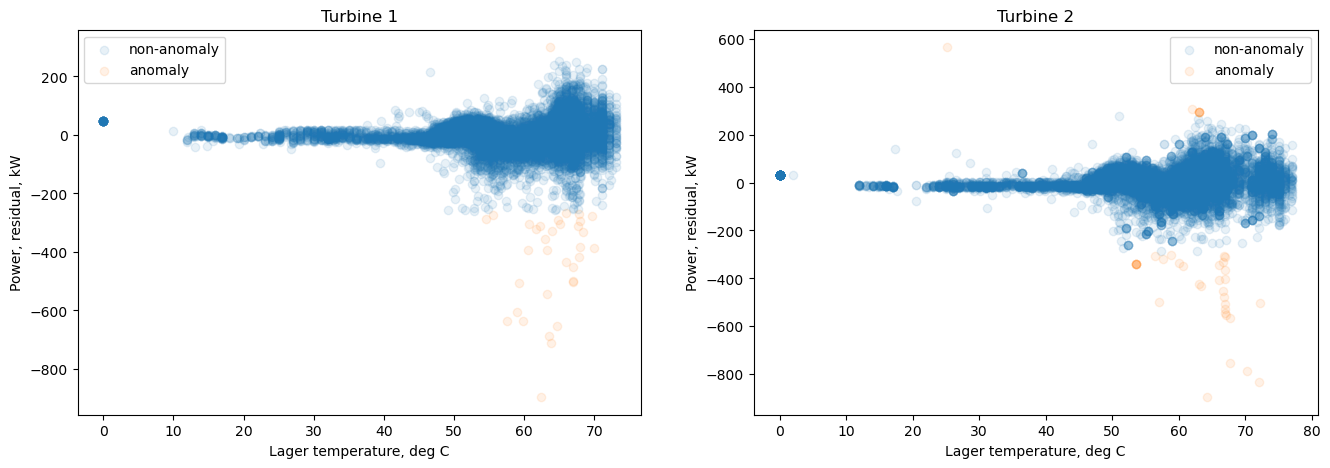

In [219]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,5))
ax1.scatter(t1[~anomaly1]['Lager'], t1[~anomaly1]['residual'], alpha = 0.1, label = 'non-anomaly')
ax1.scatter(t1[anomaly1]['Lager'], t1[anomaly1]['residual'], alpha = 0.1, label = 'anomaly')
ax2.scatter(t2[~anomaly2]['Lager'], t2[~anomaly2]['residual'], alpha = 0.1, label = 'non-anomaly')
ax2.scatter(t2[anomaly2]['Lager'], t2[anomaly2]['residual'], alpha = 0.1, label = 'anomaly')
ax1.set_ylabel('Power, residual, kW')
ax2.set_ylabel('Power, residual, kW')
ax1.set_title('Turbine 1')
ax2.set_title('Turbine 2')
ax1.set_xlabel('Lager temperature, deg C')
ax2.set_xlabel('Lager temperature, deg C')
ax1.legend()
ax2.legend()

print(f"All type A anomalies of turbine 1 occur at Lager temperatures of > {t1[anomaly1]['Lager'].min()} C")
print(f"All type A anomalies of turbine 2 occur at Lager temperatures of > {t2[anomaly2]['Lager'].min()} C")

So there is a slight pattern in terms of the temperature when anomalies start to become present, but not a strong enough one that could warrant any policies for checking turbine function, given a certain temperature.

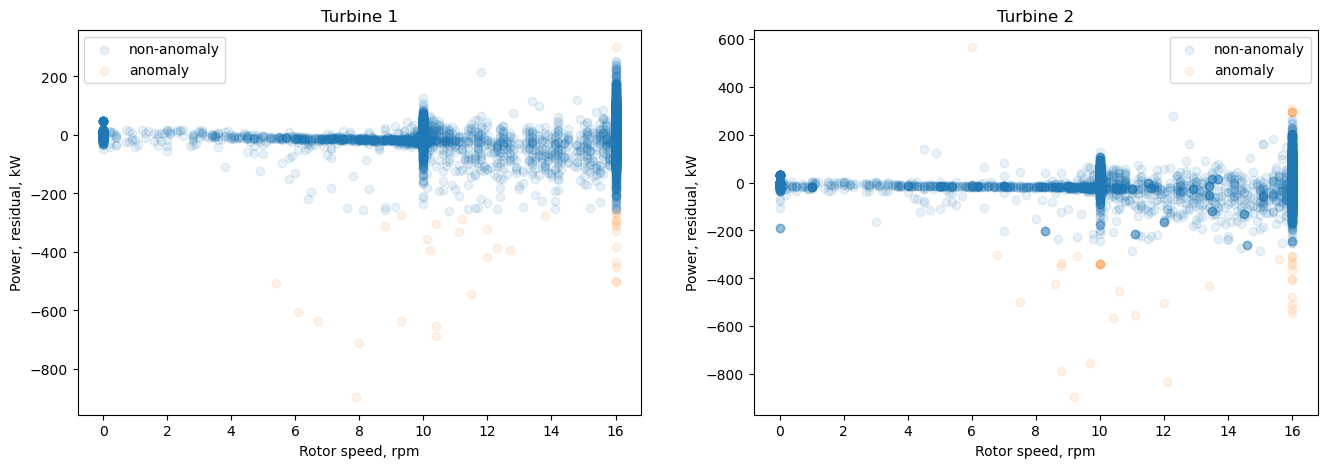

In [220]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,5))
ax1.scatter(t1[~anomaly1]['Rotor'], t1[~anomaly1]['residual'], alpha = 0.1, label = 'non-anomaly')
ax1.scatter(t1[anomaly1]['Rotor'], t1[anomaly1]['residual'], alpha = 0.1, label = 'anomaly')
ax2.scatter(t2[~anomaly2]['Rotor'], t2[~anomaly2]['residual'], alpha = 0.1, label = 'non-anomaly')
ax2.scatter(t2[anomaly2]['Rotor'], t2[anomaly2]['residual'], alpha = 0.1, label = 'anomaly')
ax1.set_ylabel('Power, residual, kW')
ax2.set_ylabel('Power, residual, kW')
ax1.set_xlabel('Rotor speed, rpm')
ax2.set_xlabel('Rotor speed, rpm')
ax1.set_title('Turbine 1')
ax2.set_title('Turbine 2')
ax1.legend()
ax2.legend()

Again, no strong patterns from a diagnostic standpoint